# Enron POI Detection Project

### Background

At the end of 2001, it was revealed that Enron's reported financial condition was sustained by institutionalized, systematic, and creatively planned accounting fraud, which has since become a well-known example of willful corporate fraud and corruption. When Enron declared bankruptcy on December 2, 2001, for the majority of 20,000 staff, this was the end of their livelihood. However for a very few people who had insider knowledge of these fraudulent practices, they managed to profit before the downfall of the company. 

The purpose of this project is to identify such persons of interest (POI) using both email and financial data. In the process of identifying these POIs, we will be applying machine learning techniques broken down into five major steps:

1. Data Exploration
2. Feature Creation & Selection
3. Algorithm Selection
4. Fine Tuning
5. Cross validation

### Data Exploration

The first step was to load the dataset and understand the structure of the data and features available. 

In [1]:
import pickle

### load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r"))

poi_count = 0

print "Number of persons: ", len(data_dict.keys())
for person in data_dict.keys():
    if data_dict[person]["poi"]:
        poi_count += 1
print "Number of POI: ", poi_count
print "Number of features per person: ", len(data_dict[data_dict.keys()[0]])

Number of persons:  146
Number of POI:  18
Number of features per person:  21


The key callouts from the query above is that the dataset contains 146 entities (i.e. persons), of which 18 have been identified as persons of interest (POI), and for each person, 21 attributes are provided. Of the 21 attributes, there are three major categories of features: financial (e.g. salary, bonus), email (e.g. to_messages, from_messages), and person of interest label (i.e. poi). It should be noted that for some individuals, some of the attribute values are "NaN" (i.e. not available). A summary of the number of "NaN" values by feature are provided below:

In [2]:
print "FEATURE", " "*(25-len("FEATURE")), "# MISSING VALUES" 
print "-------------------------------------------"
for feature in data_dict[data_dict.keys()[0]]:
    count = 0
    for person in data_dict.iteritems():
        if person[1][feature] == "NaN":
            count += 1
    print feature, " "*(32-len(feature)), count

FEATURE                    # MISSING VALUES
-------------------------------------------
salary                            51
to_messages                       60
deferral_payments                 107
total_payments                    21
exercised_stock_options           44
bonus                             64
restricted_stock                  36
shared_receipt_with_poi           60
restricted_stock_deferred         128
total_stock_value                 20
expenses                          51
loan_advances                     142
from_messages                     60
other                             53
from_this_person_to_poi           60
poi                               0
director_fees                     129
deferred_income                   97
long_term_incentive               80
email_address                     35
from_poi_to_this_person           60


It would appear from the results above that loan_advances, director_fees and restricted_stock_deferred would be poor features to use in identifying POIs as the majority of individuals in the dataset do not have any information for these features. 

Next was to identify and remove any outliers:

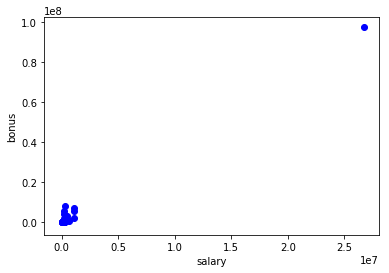

In [3]:
import matplotlib.pyplot as plt
from feature_format import featureFormat, targetFeatureSplit

features = ["salary", "bonus"]
data = featureFormat(data_dict, features)

for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus, color = "b" )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

In [4]:
data_dict_salary = []
for person in data_dict:
    value = data_dict[person]['salary']
    if value != 'NaN':
        data_dict_salary.append((person, int(value)))

# prints top 5 outliers based on salary
outliers = (sorted(data_dict_salary,key=lambda x:x[1],reverse=True)[:5])
print "NAME", " "*(25-len("NAME")), "SALARY"
print "------------------------------------"
for name, salary in outliers:
    print name, " "*(25-len(name)), salary

NAME                       SALARY
------------------------------------
TOTAL                      26704229
SKILLING JEFFREY K         1111258
LAY KENNETH L              1072321
FREVERT MARK A             1060932
PICKERING MARK R           655037


The main outlier was found to be "TOTAL", which is the sum of all the salaries. Another data point that did not make sense to keep was "THE TRAVEL AGENCY IN THE PARK". The following code was run to remove these two data point and replot the salary versus bonus graph: 

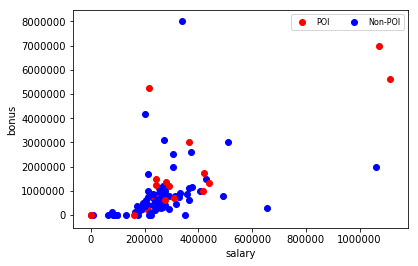

In [5]:
data_dict.pop('TOTAL', 0)
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', 0)

features = ["salary", "bonus", "poi"]
data = featureFormat(data_dict, features)

for point in data:
    salary = point[0]
    bonus = point[1]
    # marking POI as red and non-POI as blue
    if point[2] ==  1:
        poi = plt.scatter( salary, bonus, color = "r" )
    else:
        non_poi = plt.scatter( salary, bonus, color = "b" )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.legend((poi, non_poi),
           ('POI', 'Non-POI'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=8)
plt.show()

### Feature Creation & Selection

From the start it was clear that "email_address" and "other" did not need to be considered in the feature selection process as a person's "email_address" would have little influence whether or not they would be considered a person of interest and "other" was too vague to be considered meaningful for our analysis. 

Additionally, it would be reasonable to conclude that the "from_poi_to_this_person" and "from_this_person_to_poi" values would not be as clear an indicator of a person's POI status as the proportion of total email messages sent to and from this person to a POI. Therefore the following two features were created: 
1. from_poi_to_this_person_ratio  
2. from_this_person_to_poi_ratio

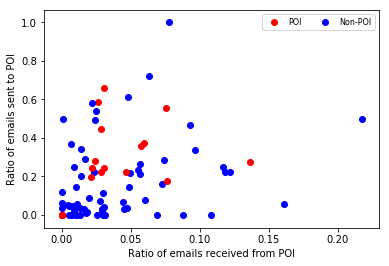

In [6]:
for person in data_dict:
    data_dict[person]["from_this_person_to_poi_ratio"]=0
    data_dict[person]["from_poi_to_this_person_ratio"]=0
    
    to_messages = float(data_dict[person]["to_messages"])
    from_messages = float(data_dict[person]["from_messages"])
    from_poi_to_this_person = float(data_dict[person]["from_poi_to_this_person"])
    from_this_person_to_poi = float(data_dict[person]["from_this_person_to_poi"])
    
    if from_messages > 0 and from_this_person_to_poi != "NaN":
        data_dict[person]["from_this_person_to_poi_ratio"] = from_this_person_to_poi/from_messages
    if to_messages > 0 and from_poi_to_this_person != "NaN":
        data_dict[person]["from_poi_to_this_person_ratio"] = from_poi_to_this_person/to_messages

features = ["from_this_person_to_poi_ratio", "from_poi_to_this_person_ratio", "poi"]
data = featureFormat(data_dict, features)

for point in data:
    from_this_person_to_poi_ratio = point[0]
    from_poi_to_this_person_ratio = point[1]
    # marking POI as red and non-POI as blue
    if point[2] ==  1:
        poi = plt.scatter( from_poi_to_this_person_ratio, from_this_person_to_poi_ratio, color = "r")
    else:
        non_poi = plt.scatter( from_poi_to_this_person_ratio, from_this_person_to_poi_ratio, color = "b")

plt.xlabel("Ratio of emails received from POI")
plt.ylabel("Ratio of emails sent to POI")
plt.legend((poi, non_poi),
           ('POI', 'Non-POI'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=8)
plt.show()

To identify the most influential features, the SelectKBest module was utilized in tandem with the MinMaxScalar to ensure features were weighted equally. The initial feature list used for the feature selection process is as per below. Do note the to_messages, from_messages, from_poi_to_this_person and from_this_person_to_poi features were removed as their value is captured by the newly created features, from_this_person_to_poi_ratio and from_poi_to_this_person_ratio:

features_list = ['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances',
                 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value',
                 'expenses', 'exercised_stock_options', 'long_term_incentive',
                 'restricted_stock', 'director_fees', 'shared_receipt_with_poi', 'from_this_person_to_poi_ratio',                            'from_poi_to_this_person_ratio']

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest

features_list = ['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances',
                 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value',
                 'expenses', 'exercised_stock_options', 'long_term_incentive',
                 'restricted_stock', 'director_fees', 'shared_receipt_with_poi', 'from_this_person_to_poi_ratio',
                 'from_poi_to_this_person_ratio']

data = featureFormat(data_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Scale features via min-max
scaler = MinMaxScaler()
features = scaler.fit_transform(features)
# feature selection
selection = SelectKBest()
selection.fit(features, labels)

results = zip(features_list[1:], selection.scores_)
results = sorted(results, key=lambda x: x[1], reverse=True)
print "FEATURE", " "*(29-len("FEATURE")), "KBEST SCORE"
print "----------------------------------------------"
for feature, score in results:
    print feature, " "*(32-len(feature)), round(score,2) 

FEATURE                        KBEST SCORE
----------------------------------------------
exercised_stock_options           24.82
total_stock_value                 24.18
bonus                             20.79
salary                            18.29
from_this_person_to_poi_ratio     16.41
deferred_income                   11.46
long_term_incentive               9.92
restricted_stock                  9.21
total_payments                    8.77
shared_receipt_with_poi           8.59
loan_advances                     7.18
expenses                          6.09
from_poi_to_this_person_ratio     3.13
director_fees                     2.13
deferral_payments                 0.22
restricted_stock_deferred         0.07


From the SelectKBest module, the top 5 features to identify a person of interest is as such:
1. Exercised stock options
2. Total stock value
3. Bonus
4. Salary
5. Ratio of email messages sent from this person to a POI

The next question to tackle was to determine the optimum number of features that should be used as well as the algorithm that would produce the best precision and recall values.

### Algorithm Selection

Four algorithms, GaussianNB, RandomForestClassifer, AdaBoostClassifier, and KNeighborsClassifier, were selected to compare against each other based on accuracy, precision, recall, and F1 score. For each algorithm, the number of features used to train and test the classifier were varied so as to ascertain the optimum number of features. 

Based on the results from the feature selection process, the feature list was re-ordered to prioritize the features with the better K-best scores. Please refer to the re-ordered feature list below: 

features_list = ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 'from_this_person_to_poi_ratio',                  'deferred_income',  'long_term_incentive', 'restricted_stock', 'total_payments', 'shared_receipt_with_poi',                  'loan_advances', 'expenses', 'from_poi_to_this_person_ratio', 'director_fees', 'deferral_payments',
                 'restricted_stock_deferred']

C:\Users\Darryl\Anaconda3\envs\py2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


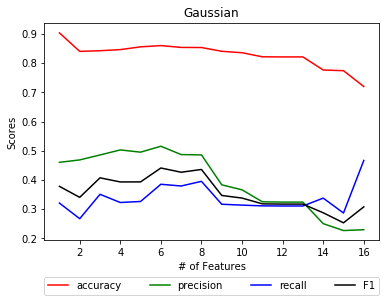

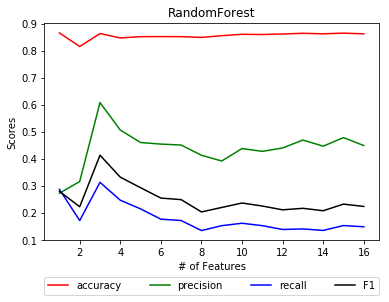

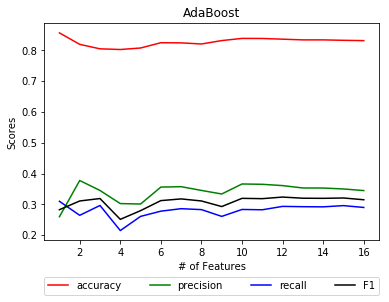

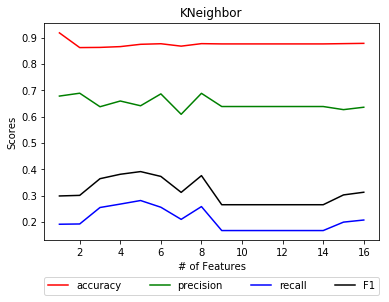

In [8]:
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import *
from tester import dump_classifier_and_data, load_classifier_and_data, test_classifier

features_list = ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 
                 'from_this_person_to_poi_ratio', 'deferred_income',  'long_term_incentive', 
                 'restricted_stock', 'total_payments', 'shared_receipt_with_poi', 
                 'loan_advances', 'expenses', 'from_poi_to_this_person_ratio', 'director_fees', 
                 'deferral_payments', 'restricted_stock_deferred']
    
algorithms = ["Gaussian", "RandomForest", "AdaBoost", "KNeighbor"]
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

count = 0
for algorithm in algorithms:
    accuracy_values.append([])
    precision_values.append([])
    recall_values.append([])
    f1_values.append([])
    feature_no = []
    

    i = 1
    while i < len(features_list):
        features_sublist = features_list[:i+1]

        #Define classifiers
        if algorithm == "Gaussian":
            clf = GaussianNB()
        elif algorithm == "RandomForest":
            clf = RandomForestClassifier()
        elif algorithm == "AdaBoost":
            clf = AdaBoostClassifier()
        elif algorithm == "KNeighbor":
            clf = KNeighborsClassifier()
        
        dump_classifier_and_data(clf, data_dict, features_sublist)
        clf_test, dataset_test, feature_list_test = load_classifier_and_data()
        
        accuracy, precision, recall, f1 = test_classifier(clf_test, dataset_test, feature_list_test, False)
        accuracy_values[count].append(accuracy)
        precision_values[count].append(precision)
        recall_values[count].append(recall)
        f1_values[count].append(f1)
        
        feature_no.append(i)
        i += 1
    
    accuracy_plot = plt.plot( feature_no, accuracy_values[count], color = "r", label="accuracy")
    precision_plot = plt.plot( feature_no, precision_values[count], color = "g", label="precision")
    recall_plot = plt.plot( feature_no, recall_values[count], color = "b", label="recall")
    f1_plot = plt.plot( feature_no, f1_values[count], color = "black", label="F1")
    plt.xlabel("# of Features")
    plt.ylabel("Scores")
    plt.title(algorithm)
    plt.legend(bbox_to_anchor=(0., -0.25, 1., .102), loc=3, ncol=4, mode="expand", borderaxespad=0.)
    plt.show()
    
    count += 1


The graphs above illustrate that each algorithm is optimal at different number of features (excluding poi as a feature):
1. Gaussian: 6 features
2. RandomForest: 3 features
3. AdaBoost: 7 features
4. KNeighbors: 5 features

In order to select which was the best algorithm, however, I had to consider the objective of the exercise. If the objective was to identify as many POI as possible even at the expense of possibly identifying non-POI persons as POI (i.e. false positive), then a high precision value was not priority. However, if the objective was to narrow down the list of suspects and not accidentally investigate persons of no interest at the expense of possibly identifying some POI as non-POI (i.e. false negative), then a high recall value  was not priority. Eventually, I deemed both recall and precision to be of equal value and thus decided to use the F1 score to decide which algorithm to use:

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import *
from tester import dump_classifier_and_data, load_classifier_and_data, test_classifier

optimum_feature_no = [6, 3, 7, 5]
features_list = ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 
                 'from_this_person_to_poi_ratio', 'deferred_income',  'long_term_incentive', 
                 'restricted_stock', 'total_payments', 'shared_receipt_with_poi', 
                 'loan_advances', 'expenses', 'from_poi_to_this_person_ratio', 'director_fees', 
                 'deferral_payments', 'restricted_stock_deferred']

algorithms = ["Gaussian", "RandomForest", "AdaBoost", "KNeighbor"]
accuracy_optimum_values = []
precision_optimum_values = []
recall_optimum_values = []
f1_optimum_values = []

for i, algorithm in enumerate(algorithms):
    feature_no = []

    features_sublist = features_list[:optimum_feature_no[i]+1]

    #Define classifiers
    if algorithm == "Gaussian":
        clf = GaussianNB()
    elif algorithm == "RandomForest":
        clf = RandomForestClassifier()
    elif algorithm == "AdaBoost":
        clf = AdaBoostClassifier()
    elif algorithm == "KNeighbor":
        clf = KNeighborsClassifier()
        
    dump_classifier_and_data(clf, data_dict, features_sublist)
    clf_test, dataset_test, feature_list_test = load_classifier_and_data()
        
    accuracy, precision, recall, f1 = test_classifier(clf_test, dataset_test,
                                                      feature_list_test, False)
    accuracy_optimum_values.append(accuracy)
    precision_optimum_values.append(precision)
    recall_optimum_values.append(recall)
    f1_optimum_values.append(f1)

print "ALGORITHM", " "*(15-len("ALGORITHM")), "# OF FEATURES", " "* \
    (18-len("# OF FEATURES")), "F1 SCORE"
print "-------------------------------------------------"
for i, algorithm in enumerate(algorithms):
    features = optimum_feature_no[i]
    print algorithm, " "*(20-len(algorithm)), features, " "*13, \
        round(f1_optimum_values[i],4)
    
print ""
print "Gaussian Naive Bayes"
index = 0
print "Number of features: ", optimum_feature_no[index]
print "Accuracy:  ", round(accuracy_optimum_values[index],4)
print "Precision: ", round(precision_optimum_values[index],4)
print "Recall:    ", round(recall_optimum_values[index],4)

ALGORITHM        # OF FEATURES       F1 SCORE
-------------------------------------------------
Gaussian              6               0.4412
RandomForest          3               0.4061
AdaBoost              7               0.315
KNeighbor             5               0.3918

Gaussian Naive Bayes
Number of features:  6
Accuracy:   0.8605
Precision:  0.5157
Recall:     0.3855


Based on the F1 scores, I decided to select the Gaussian Naive Bayes algorithm, which had an accuracy of 0.8605, precision value of 0.5157, and recall value of 0.3855 when 6 features are used to create the training and testing datasets. 

### Fine Tuning

Once an algorithm had been selected, the next step was to fine tune the parameters of the chosen algorithm in order to extract its best performance. Because the GaussianNB classifier does not have any parameters, no fine tuning was required for this particular algorithm. However as practice, I used GridSearchCV on the KNeighbor classifier to see if I could fine tune the parameters to obtain a better performance. 

Fine tuning is the process of toggling through parameters and testing an algoritm to obtain the optimal mix or settings which produces the best results. If you do not tune your algorithm, you could end up with a model that seems correct based on a few metrics that you have used to benchmark performance (e.g. accuracy) but is actually a poor classifer overall. With GridSearchCV, it takes all possible combinations of paramaters into account and uses a multitude of metrics (e.g. accuracy, recall, precision, f1) to assist in identifying the classifer that provides the best score overall. 

In [10]:
print "Before Fine Tuning Parameters:"
print "KNeighbor"
index = 3
print "Number of features: ", optimum_feature_no[index]
print "Accuracy:  ", round(accuracy_optimum_values[index],4)
print "Precision: ", round(precision_optimum_values[index],4)
print "Recall:    ", round(recall_optimum_values[index],4)
print "F1 score:  ", round(f1_optimum_values[index],4)

Before Fine Tuning Parameters:
KNeighbor
Number of features:  5
Accuracy:   0.8749
Precision:  0.6416
Recall:     0.282
F1 score:   0.3918


As part of the fine tuning process of the KNeighbors algorithm, the following parameters were  tuned:
1. n_neighbors
2. leaf_size
3. algorithm

In [11]:
from sklearn.grid_search import GridSearchCV

features_sublist = features_list[:optimum_feature_no[index]+1]

parameters = {"n_neighbors":[4, 5, 6], "leaf_size":[20, 30, 40],
              "algorithm":["auto", "ball_tree", "brute"]}
clf_kn = KNeighborsClassifier()
clf = GridSearchCV(clf_kn, parameters)

dump_classifier_and_data(clf, data_dict, features_sublist)
clf_test, dataset_test, feature_list_test = load_classifier_and_data()

accuracy, precision, recall, f1 = test_classifier(clf_test, dataset_test,
                                                  feature_list_test, False)
print "After Fine Tuning Parameters:"
print "KNeighbor"
index = 3
print "Number of features: ", optimum_feature_no[index]
print "Accuracy:  ", round(accuracy,4)
print "Precision: ", round(precision,4)
print "Recall:    ", round(recall,4)
print "F1 score:  ", round(f1,4)

C:\Users\Darryl\Anaconda3\envs\py2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


After Fine Tuning Parameters:
KNeighbor
Number of features:  5
Accuracy:   0.8697
Precision:  0.656
Recall:     0.185
F1 score:   0.2886


From the fine tuning process, the precision improved marginally from 0.64 to 0.66 but the recall decreased from 0.28 to 0.19, causing the F1 score to decline from 0.39 to 0.29. This, however, shows that the precision of a model can be improved by simply tweaking a classifier's parameters.

### Cross validation

Validation is the process of dividing data into two segments, one dataset to train the model and the other dataset to test the model. The purpose of doing this is to avoid overfitting where the algorithm is only able to predict based on the training dataset and is unable to generalize when given untrained data. For this project, the Stratified Shuffle Split was used to randomly create training and testing datasets.

For this particular case the Stratified Shuffle Split was used for cross-validation because we were aware of the unbalanced nature of the dataset as there were only 18 POI and 128 non POI entities in the dataset. Stratified Shuffle Split allows for randomization but also makes sure these unbalanced datasets have some of both classes.

### Conclusion

In conclusion, based on F1 scoring, the Gaussian Naive Bayes algorithm was chosen as the best model to best identify persons of interest in the Enron fraud case. To simplify the analysis, only the following 6 features were selected to train and test the model as it was found these 6 features produced the optimum performance in the Gaussian Naive Bayes algorithm:
1. Exercised stock options
2. Total stock value
3. Bonus
4. Salary
5. Ratio of email messages from person to POI
6. Deferred income

With a precision of 51.6% and recall value of 38.6%, this means that 51.6% of the time, when the model predicts a POI, this person is indeed a POI and 38.6% of the time, the model can correctly identifying a POI. 

In [12]:
clf = GaussianNB()
features_list = ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 
                 'salary', 'from_this_person_to_poi_ratio', 'deferred_income']

dump_classifier_and_data(clf, data_dict, features_list)